In [24]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time
from astropy.time import Time

plt.rcParams.update({'font.size': 12})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'


In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].Gaia_RPmag = gfits[1].data['Gaia_RPmag'][i]
                field[obj].Gaia_BPmag = gfits[1].data['Gaia_BPmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
                field[obj].BPminusRP = field[obj].Gaia_BPmag - field[obj].Gaia_RPmag
#         print gfits[1].header

    return field

In [3]:
def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
pdics = {}
fieldnames = []
field_pattern = re.compile(r'^NG\d+[+|-]\d+$')

for f in os.listdir(ROOT_DIR):
    if re.match(field_pattern, f):
        fieldnames.append(f)
print "Found {} fields".format(len(fieldnames))
# print fieldnames
# fieldnames = fieldnames[1:5]
# fieldnames = ['NG2346-3633']

for field in fieldnames:
    field_dir = os.path.join(ROOT_DIR, field)
    pdic_filename = 'NGTS_Field_{}_pdic.json'.format(field)
    if pdic_filename in os.listdir(field_dir):
        with open(os.path.join(*[ROOT_DIR, field, pdic_filename])) as f:
            pdics[field] = json.load(f)
            pdics[field] = {int(k):v for k,v in pdics[field].iteritems()}
            

# fieldnames = pdics.keys()
# fieldnames = ['NG0004-2950']
# with open('/home/jtb34/rds/hpc-work/GACF_OUTPUTS/NG0535-0523/NGTS_Field_NG0535-0523_pdic.json', 'r') as f:
#     pdic = json.load(f)

# pdic = {int(k):v for k,v in pdic.iteritems()}


object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
obj_lists = {}
for field in fieldnames:
    obj_list = []
    for f in os.listdir(os.path.join(ROOT_DIR, field)):
        match = re.match(object_pattern, f)
        if match is not None:
            obj_list.append(int(match.group('obj')))
    obj_lists[field] = np.array(obj_list)
# print 'Found {} objects'.format(len(obj_list))
# print pdic

# half_moon_objs = [(k, v[0]) for k,v in pdic.iteritems() if 13<v[0]<15]
# print half_moon_objs



Found 115 fields


In [6]:
fieldsizes = {}
max_size = 0
for k, v in pdics.iteritems():
    print k, len(v), 'periods'
    fieldsizes[k] = float(len(v))
#     if fieldsizes[k] > max_size:
#         max_size = fieldsizes[k]
print

for k, v in obj_lists.iteritems():
    print k, len(v), 'objects'
    try:
        fieldsizes[k] = fieldsizes[k] / float(len(v))
        if fieldsizes[k] > max_size:
            max_size = fieldsizes[k]
    except KeyError:
        pass

NG0458-3056 30 periods
NG0535-0523 496 periods
NG0518-3633 36 periods
NG1429-3056 48 periods
NG2028-2518 55 periods
NG0523-0104 191 periods
NG0532-3633 24 periods
NG1114-3056 50 periods
NG1416-2518 33 periods
NG0450-3633 16 periods
NG0914-1652 47 periods
NG0613-3633 49 periods
NG1112-3345 56 periods
NG0304-1115 374 periods
NG0504-3633 34 periods
NG2346-3633 17 periods
NG1200-3633 59 periods
NG0931-1941 39 periods
NG0537-3056 37 periods
NG0511-3056 30 periods
NG0448-3922 23 periods
NG0531-0826 115 periods
NG2142+0826 38 periods
NG0445-3056 33 periods
NG2126-1652 29 periods
NG0612-2518 65 periods
NG0618-6441 107 periods
NG0549-3345 56 periods
NG0004-2950 55 periods
NG0409-1941 38 periods
NG0603-3056 63 periods
NG0456-3345 33 periods
NG0522-2518 42 periods
NG0603-3345 53 periods
NG2331-3922 21 periods
NG0509-3345 52 periods
NG0348-3345 22 periods
NG0524-3056 44 periods
NG0502-3922 27 periods
NG0616-3345 201 periods
NG0353-3056 30 periods

NG0458-3056 5881 objects
NG1146-3633 2450 objects


In [6]:
print len(fieldsizes)
print max_size

41
0.0553756838227


In [7]:
maxl = 0
for ka in pdics.values():
    for k, v in ka.iteritems():
#         print v, '\r'
        if len(v) > maxl:
            maxl = len(v)
            print v
print maxl

[5.785]
1


In [15]:
from astropy.coordinates import get_moon, get_sun, SkyCoord, EarthLocation, AltAz
import astropy.units as u
fieldname_pattern = re.compile('^NG(\d{2})(\d{2})([+|-])(\d{2})(\d{2})$')
fieldcentres = {}
for fieldname in fieldnames:
    match = re.match(pattern=fieldname_pattern, string=fieldname)
    if match:
        field_position = match.group(1) + 'h' + match.group(2) + 'm ' + match.group(3) + match.group(4) + ':' + match.group(5)
        coord = SkyCoord(field_position, unit=(u.hourangle, u.deg), frame='gcrs')
        fieldcentres[fieldname] = coord
# print fieldcentres

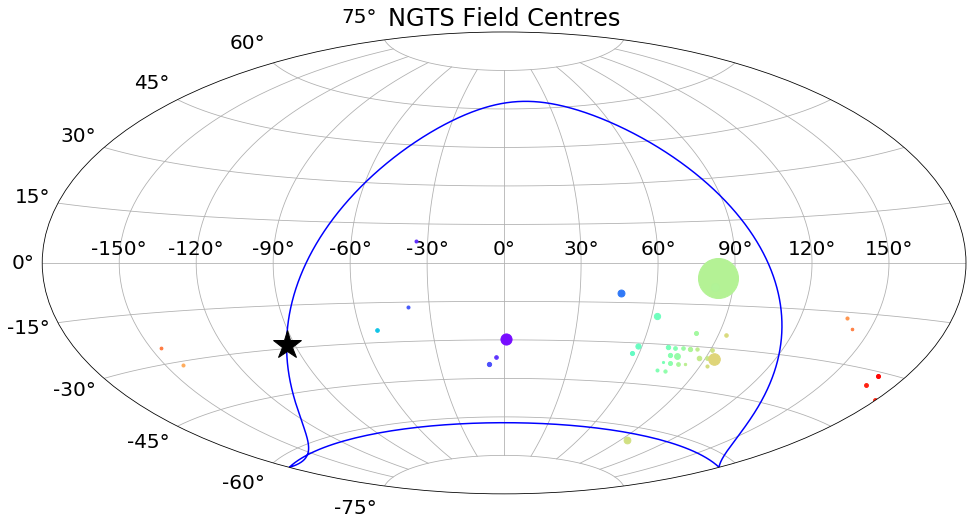

Max extraction ratio 5.54%


In [13]:
# ra_rad = [m.ra.wrap_at(180 * u.deg).radian for m in moon_sep]
# dec_rad = [m.dec.radian for m in moon_sep]
fig = plt.figure(figsize=(16.555118,16.555118))
ax = fig.add_subplot(111, projection='aitoff')
plt.title("NGTS Field Centres")
plt.grid(True)
# plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
zero_pos = SkyCoord('0 -0', unit=u.deg)
distances = [c.separation(zero_pos).radian for c in fieldcentres.values()]
norm = mpl.colors.Normalize(vmax=max(distances), vmin=min(distances))
# colors = plt.cm.cool_r(norm(np.linspace(min(distances), max(distances), len(distances))))
temp = np.array(distances).argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(distances))
colors = plt.cm.rainbow(ranks.astype(float) / max(ranks))
# ras = [c.ra.wrap_at(180*u.deg).radian for c in fieldcentres.values()]
# decs = [c.dec.radian for c in fieldcentres.values()]
i = 0
fieldcolors = {}
for f,c in fieldcentres.iteritems():
    try:
#         markersize = abs((np.log(float(fieldsizes[f])) / np.log(float(max_size)))) * 20.
        markersize = float(fieldsizes[f] / max_size) * 40.
    except KeyError:
        markersize = 0
#     distance_from_0  = c.separation(SkyCoord(0))
#     plt.plot(c.ra.wrap_at(180*u.deg).radian, c.dec.radian, 'o', markersize=10, label=f, c=colors[i])
    plt.plot(c.transform_to('icrs').ra.wrap_at(180*u.deg).radian, c.transform_to('icrs').dec.radian, 'o', 
             markersize=markersize, label=f, c=colors[i])
    fieldcolors[f] = colors[i]
    i += 1

galactic_longitudes = np.arange(start=0, stop=360, step=0.1)
galactic_latitudes = np.zeros(len(galactic_longitudes))
icrs = SkyCoord(galactic_longitudes, galactic_latitudes,
                unit="deg", frame="galactic").icrs
ra_rad = icrs.ra.wrap_at(180 * u.deg).radian
# ra_rad = icrs.ra.radian
dec_rad = icrs.dec.radian
# plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.plot(ra_rad, dec_rad, c='b')
plt.plot(ra_rad[0], dec_rad[0], '*', c='k', markersize=30)

plt.subplots_adjust(top=0.95,bottom=0.0)
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*zip(*sorted(zip(zip(labels, handles), distances), key=lambda x: x[1]))[0])
# a = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# labels, handles
# ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

# print fieldcolors

# c = ax.scatter([m.deg for m in moon_sep], np.linspace(1,1,len(ts)),c=ts)
# plt.show()
print 'Max extraction ratio {:.2f}%'.format(max_size * 100.)

In [14]:
# fieldnames = ['NG0409-1941']#,'NG0409-1941', 'NG2331-3922']
# fieldnames = ['NG2346-3633']

In [15]:
fields = {}
# gfields = {}

for fieldname in fieldnames:
    if fieldname != 'NG0458-3056':
        continue
    t1 = time.time()
    try:
        field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807',
                                                   obj_ids = pdics[fieldname].keys(),
                                                   include_empty_objects=False, silent=True)
    except KeyError:
        print 'No data loaded for field {}'.format(fieldname)
        continue
#     field = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=pdics[fieldname].keys())
    t2 = time.time()
    field = load_gaia_params(field)
    t3 = time.time()
    for obj in field:
        try:
            obj.cleaned_refined_periods = pdics[fieldname][obj.obj]
        except KeyError:
            obj.cleaned_refined_periods = None
    
#     gfield = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=obj_lists[fieldname])
#     gfield = load_gaia_params(gfield)
    
    fields[fieldname] = field
    t4 = time.time()
#     gfields[fieldname] = gfield

#     print '{} objects with periods, {} total'.format(field.num_objects, gfield.num_objects)
    print 'Loaded field in {} seconds'.format(t2-t1)
    print 'Loaded Gaia params in {} seconds'.format(t3-t2)
    print 'Finished Field in {} seconds'.format(t4-t1)
    
fieldnames = fields.keys()

matched 5881 of 6125 files. Loaded 30 objects
Loaded field in 0.682229995728 seconds
Loaded Gaia params in 0.157296180725 seconds
Finished Field in 0.839557170868 seconds


In [16]:
# for fieldname, field in fields.iteritems():
#     fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
#     field.load_from_fits(fits_file, obj_ids=field.objects.keys(), method='fitsio')

In [17]:
xmatch_ids = {}
xmatch_paths = [os.path.join(XMATCH_LOCATION.format(fieldname),
                               XMATCH_FILE_NAME.format(fieldname)) for fieldname in fieldnames]
for xmatch_path, fieldname in zip(xmatch_paths, fieldnames):
    with fits.open(xmatch_path) as gfits:
        xmatch_ids[fieldname] = {k: v for k, v in zip(map(int,gfits[1].data['Sequence_number']), gfits[1].data['Gaia_Source_ID'])}

In [18]:
# only take relevant cross matches
for k, v in xmatch_ids.iteritems():
    obj_list = fields[k].objects.keys()
    xmatch_ids[k] = {k1: v1 for k1, v1 in v.iteritems() if k1 in obj_list}
    v = xmatch_ids[k]
    print k, len(v), 'Gaia xmatches'
    
# print xmatch_ids

NG0458-3056 30 Gaia xmatches


In [19]:
', '.join(map(str, gaia_ids))
len(gaia_ids)

NameError: name 'gaia_ids' is not defined

In [20]:
# gaia_seq_nums = [g[1] for g in xmatch_ids if g[1] > 0]
# print len(gaia_seq_nums)
# print gaia_seq_nums

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

from astroquery.utils.tap.core import TapPlus
from astroquery.gaia import Gaia
# gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
gaia_ids = []
for f, v in xmatch_ids.iteritems():
    for g in v.values():
        if g > 0:
            gaia_ids.append(g)
print 'Processing {} Gaia Ids'.format(len(gaia_ids))
max_rows = 5000
gaia_ids = [e for e in chunks(gaia_ids, max_rows)]
# gaia_ids = ', '.join(map(str, gaia_ids))
# print ', '.join(map(str, gaia_ids[:5]))
results = []
for gids in gaia_ids:
    job_str =  "SELECT source_id, dist.r_est, dist.r_lo, dist.r_hi, dist.r_len, \
                dist.result_flag, dist.modality_flag \n \
                FROM external.gaiadr2_geometric_distance as dist \n \
                JOIN gaiadr2.gaia_source AS src USING (source_id) \n \
                WHERE source_id IN ({})".format(', '.join(map(str, gids)))
    # print job_str
    job = Gaia.launch_job_async(job_str)
    results.append(job.get_results())
# print r

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Processing 27 Gaia Ids
Query finished.


In [86]:
# r['source_id'].tolist()
distance_dics = [{k:v for k,v in zip(map(int, r['source_id'].tolist()), r['r_est'].tolist())} for r in results]
distances =  {k: v for d in distance_dics for k, v in d.items()}

In [87]:
len(distances)

2415

In [88]:
# XMATCH_FILE2 = '1554372770065O-result.fits'
# xmatch_path2 = os.path.join(XMATCH_LOCATION.format(field.fieldname),
#                                XMATCH_FILE2)
# with fits.open(xmatch_path2) as gfits:
#     print gfits[1].header
#     distances = {k:v for k,v in zip(gfits[1].data['source_id'], gfits[1].data['r_est'])}

In [89]:
print len(distances)
# print len(xmatch_ids)

2415


In [90]:
np.log10

<ufunc 'log10'>

In [91]:
import numpy as np
for fieldname, field in fields.iteritems():
    for obj in field:
        try:
            obj.gaia_source_id = xmatch_ids[fieldname][obj.obj]
            obj.distance = distances[obj.gaia_source_id]
#             obj.distance = np.divide(1000., obj.Gaia_Parallax)
            obj.Abs_Gmag = obj.Gaia_Gmag - 5 * np.log10(obj.distance) + 5
        except (KeyError, AttributeError, Exception) as e:
    #         print '{} no distance found'.format(obj)
            obj.distance = None
            obj.Abs_Gmag = None

# for gfield in gfields.values():          
#     for obj in gfield:
# #         obj.gaia_source_id = xmatch_ids[obj.obj]
#         try:
# #             obj.distance = distances[obj.gaia_source_id]
#             obj.distance = np.divide(1000., obj.Gaia_Parallax)
#             obj.Abs_Gmag = obj.Gaia_Gmag - 5 * np.log10(obj.distance) + 5
#         except KeyError:
#     #         print '{} no distance found'.format(obj)
#             obj.distance = None
#             obj.Abs_Gmag = None
    

In [92]:
# for obj in field:
#     try:
#         print 'Parallax {}, 1 / Parallax {}, distance {}'.format(obj.Gaia_Parallax, 
#                                                                  1000. / obj.Gaia_Parallax,
#                                                                  obj.distance)
#     except Exception as e:
#         raise e

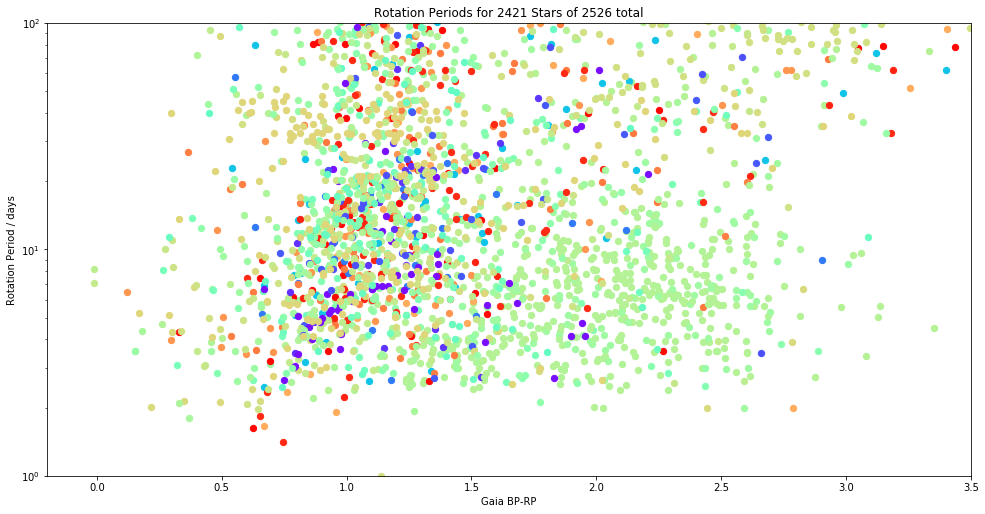

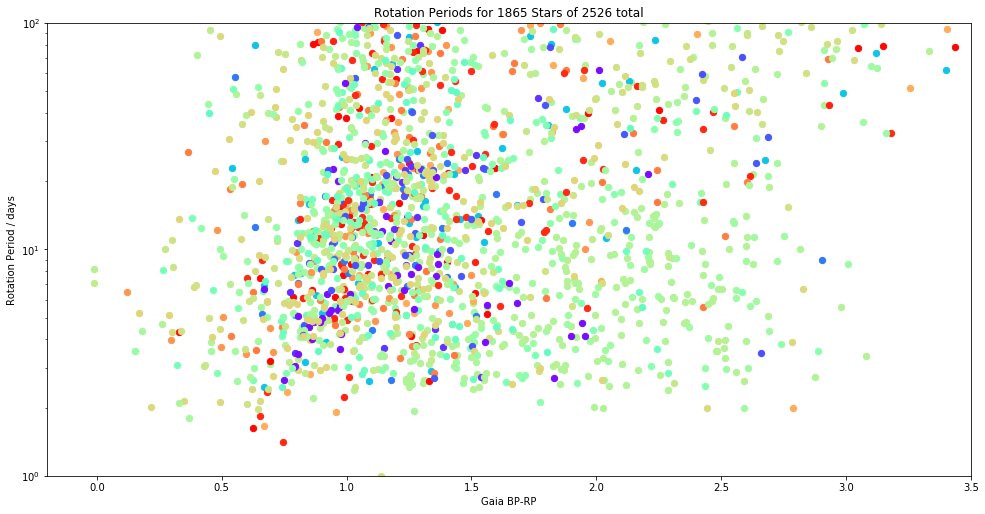

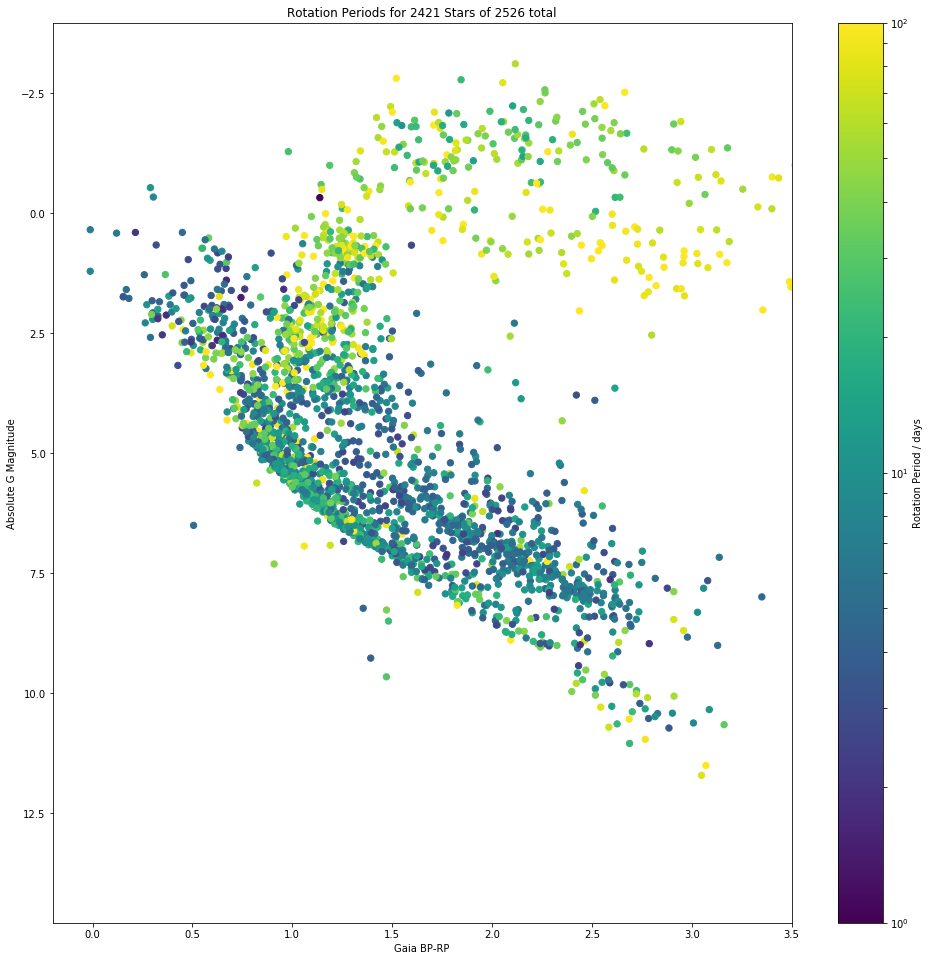

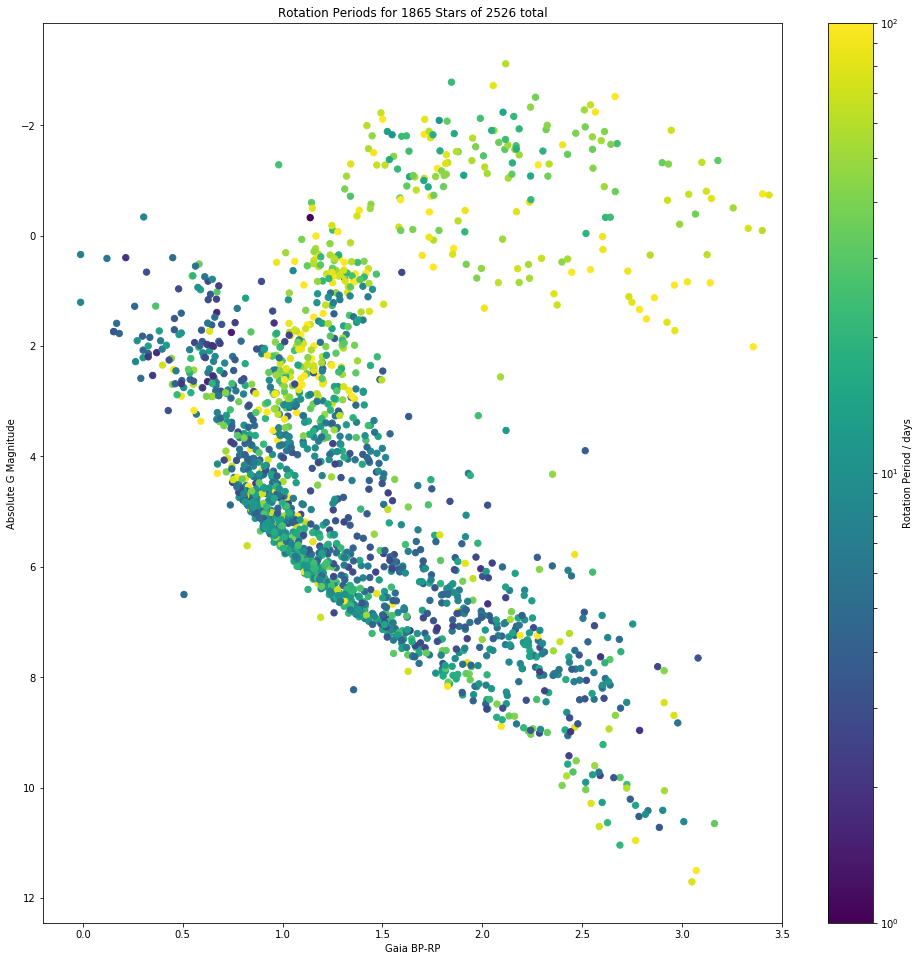

In [98]:
fig, ax = plt.subplots(figsize=(16.555118,16.555118*0.4))
figu, axu = plt.subplots(figsize=(16.555118,16.555118*0.4))
GminusK, AbsG, prot = [], [], []
GminusK_bkg, AbsG_bkg = [], []
GminusKu, AbsGu, protu = [], [], []
GminusK_bkgu, AbsG_bkgu = [], []
objcount = 0
pcount =  0
for fieldname, field in fields.iteritems():
    GminusK_f, AbsG_f, prot_f = [], [], []
    for obj in field:
        objcount += 1
        if obj.Abs_Gmag is not None:
            if obj.cleaned_refined_periods:
                for p in obj.cleaned_refined_periods:
                    pcount += 1
                    GminusK_f.append(obj.BPminusRP)
                    AbsG_f.append(obj.Abs_Gmag)
                    prot_f.append(p)
            else:
                GminusK_bkg.append(obj.BPminusRP)
                AbsG_bkg.append(obj.Abs_Gmag)
                
    ax.scatter(GminusK_f, prot_f, s=40, label=fieldname, c=fieldcolors[fieldname])
    prot.append(prot_f)
    GminusK.append(GminusK_f)
    AbsG.append(AbsG_f)
    
    prot_f = np.array(prot_f)
    idx_sort = np.argsort(prot_f)
    sorted_prot = prot_f[idx_sort]
    vals, idx_start, count = np.unique(sorted_prot, return_counts=True, return_index=True)
    # sets of indices
    res = np.split(idx_sort, idx_start[1:])
    #filter them with respect to their size, keeping only items occurring more than once
    vals = vals[count <= 1]
    res = filter(lambda x: x.size <= 1, res)
#     res = [x for x in res if len(x) <=1]
    idxu = np.hstack(res)  
    
# #     _, idxu, counts = np.unique(prot_f, return_index=True, return_counts=True)
#     print 'max count: {}'.format(max(count))
    prot_f = prot_f[idxu]
    GminusK_f = (np.array(GminusK_f))[idxu]
    AbsG_f = (np.array(AbsG_f))[idxu]
    protu.append(prot_f)
    GminusKu.append(GminusK_f)
    AbsGu.append(AbsG_f)
    axu.scatter(GminusK_f, prot_f, s=40, label=fieldname, c=fieldcolors[fieldname])
#     print len(np.unique(prot_f)) == len(prot_f)

prot = np.hstack(prot).flatten()
GminusK = np.hstack(GminusK).flatten()
AbsG = np.hstack(AbsG).flatten()
protu = np.hstack(protu).flatten()
GminusKu = np.hstack(GminusKu).flatten()
AbsGu = np.hstack(AbsGu).flatten()

for a in [ax, axu]:
    a.set_ylabel('Rotation Period / days')
    a.set_xlabel('Gaia BP-RP')
    a.set_yscale('log')

#     a.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left")

    # ax.invert_yaxis()
    #fig.legend()
    a.set_xlim([-0.2,3.5])
    a.set_ylim([1.0, 100.])
fig.subplots_adjust(top=0.95,bottom=0.0)
figu.subplots_adjust(top=0.95,bottom=0.0)
ax.set_title('Rotation Periods for {} Stars of {} total'.format(len(prot), objcount))
axu.set_title('Rotation Periods for {} Stars of {} total'.format(len(protu), objcount))
# ax.invert_xaxis()

plt.show()
        
fig, ax = plt.subplots(figsize=(16.555118,16.555118))
figu, axu = plt.subplots(figsize=(16.555118,16.555118))
ax.scatter(GminusK_bkg, AbsG_bkg, s=40, c='grey', alpha=0.1)
scat = ax.scatter(GminusK, AbsG, s=40, alpha=1, c=prot, cmap='viridis', 
                  norm=mpl.colors.LogNorm(vmin=1,vmax=100))
axu.scatter(GminusK_bkg, AbsG_bkg, s=40, c='grey', alpha=0.1)
scatu = axu.scatter(GminusKu, AbsGu, s=40, alpha=1, c=protu, cmap='viridis', 
                  norm=mpl.colors.LogNorm(vmin=1,vmax=100))

for a in [ax, axu]:
    a.set_ylabel('Absolute G Magnitude')
    a.set_xlabel('Gaia BP-RP')

    a.invert_yaxis()
    a.set_xlim([-0.2,3.5])
ax.set_title('Rotation Periods for {} Stars of {} total'.format(len(prot), objcount))
axu.set_title('Rotation Periods for {} Stars of {} total'.format(len(protu), objcount))
# ax.invert_xaxis()

# sm._A = []
cb=fig.colorbar(scat, ax=ax)
cb.set_label('Rotation Period / days')
cbu=fig.colorbar(scatu, ax=axu)
cbu.set_label('Rotation Period / days')
plt.show()

In [94]:
# for fieldname in fieldnames:

#     fig, ax = plt.subplots(figsize=(10,10))
#     GminusK, AbsG, prot = [], [], []
#     for obj in fields[fieldname]:
#         if obj.Abs_Gmag is not None:
#             if obj.cleaned_refined_periods:
#                 for p in obj.cleaned_refined_periods:
#                     GminusK.append(obj.BPminusRP)
#                     AbsG.append(obj.Abs_Gmag)
#                     prot.append(p)
#     GminusK_bkg, AbsG_bkg = [], []
#     objcount = 0
# #     for obj in gfields[fieldname]:
# #         objcount += 1
# #         if obj.Abs_Gmag is not None:
# #             GminusK_bkg.append(obj.BPminusRP)
# #             AbsG_bkg.append(obj.Abs_Gmag)

#     # _, idxu, counts = np.unique(prot, return_index=True, return_counts=True)
#     # print 'max count: {}'.format(max(counts))
#     # idxu = [i for i,c in zip(idxu, counts) if c <= 1]
#     # prot = np.array(prot)[idxu]
#     # GminusK = np.array(GminusK)[idxu]
#     # AbsG = np.array(AbsG)[idxu]

#     ax.scatter(GminusK_bkg, AbsG_bkg, s=10, c='grey', alpha=0.2)
#     scat = ax.scatter(GminusK, AbsG, s=10, alpha=1, c=prot, cmap='cool_r', 
#                       norm=mpl.colors.LogNorm(vmin=1,vmax=200))
#     ax.set_ylabel('Absolute G Magnitude')
#     ax.set_xlabel('Gaia BP-RP')

#     ax.invert_yaxis()
#     ax.set_xlim([-1,4])
#     ax.set_title('Rotation Periods for {} {} Stars of {} total'.format(fieldname, len(prot), objcount))
#     # ax.invert_xaxis()

#     # sm._A = []
#     cb=fig.colorbar(scat, ax=ax)
#     cb.set_label('Rotation Period / days')
#     plt.show()

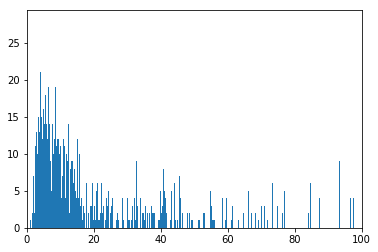

In [95]:
plt.hist(prot, bins=np.arange(min(prot), max(prot), 0.1))
plt.xlim([0, 100])
plt.show()

In [96]:
print len(prot)
print len(np.unique(prot))

2421
787


In [97]:
plt.hist(counts, bins=13, lw=1)
plt.show()

NameError: name 'counts' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(16.555118,16.555118))
objcount = 0
for fieldname, field in fields.iteritems():
    GminusK, AbsG, prot = [], [], []
    GminusK_bkg, AbsG_bkg = [], []
    for obj in field:
        objcount += 1
        if obj.Abs_Gmag is not None:
            if obj.cleaned_refined_periods:
                for p in obj.cleaned_refined_periods:
                    GminusK.append(obj.BPminusRP)
                    AbsG.append(obj.Abs_Gmag)
                    prot.append(p)
            else:
                GminusK_bkg.append(obj.BPminusRP)
                AbsG_bkg.append(obj.Abs_Gmag)
    _, idxu, counts = np.unique(prot, return_index=True, return_counts=True)
    print 'max count: {}'.format(max(counts))
    idxu = [i for i,c in zip(idxu, counts) if c <= 2]
    prot = np.array(prot)[idxu]
    GminusK = np.array(GminusK)[idxu]
    AbsG = np.array(AbsG)[idxu]
        
    ax.scatter(GminusK, prot, s=10, label=fieldname, c=fieldcolors[fieldname])
                

# objcount = 0
# for gfield in gfields.values():
#     for obj in gfield:
#         objcount += 1
#         if obj.Abs_Gmag is not None:
#             GminusK_bkg.append(obj.BPminusRP)
#             AbsG_bkg.append(obj.Abs_Gmag)
        

ax.set_ylabel('Rotation Period / days')
ax.set_xlabel('Gaia BP-RP')
ax.set_yscale('log')

# ax.invert_yaxis()
fig.legend()
ax.set_xlim([-1,4])
ax.set_title('Rotation Periods for {} Stars of {} total'.format(len(prot), objcount))
# ax.invert_xaxis()

plt.show()

In [ ]:
fieldname = fieldnames[0]
field = fields[fieldname]
cp = 0
for obj in field:
    if obj.cleaned_refined_periods:
        cp += 1
#     else:
#         print obj.ok
#         obj.ok = False
# field.remove_bad_objects()
print fieldname
print cp, field.num_objects

In [ ]:
obj_list_r = np.array(field.objects.keys())
obj_list_r = obj_list_r[np.random.randint(0, len(obj_list_r), size=10)]
obj_list = []
# for obj in [field[o] for o in obj_list_r]:
#     if obj.cleaned_refined_periods and obj.obj not in obj_list:
#         if obj.cleaned_refined_periods[0] > 20:
#             if len(obj.periods) < 5:
#                 obj_list.append(obj.obj)
for obj, periods in pdics[fieldname].iteritems():
    if periods[0] > 32.:
        obj_list.append(obj)
        
obj_list = np.array(obj_list)[np.random.randint(0, len(obj_list), size=5)]
print obj_list

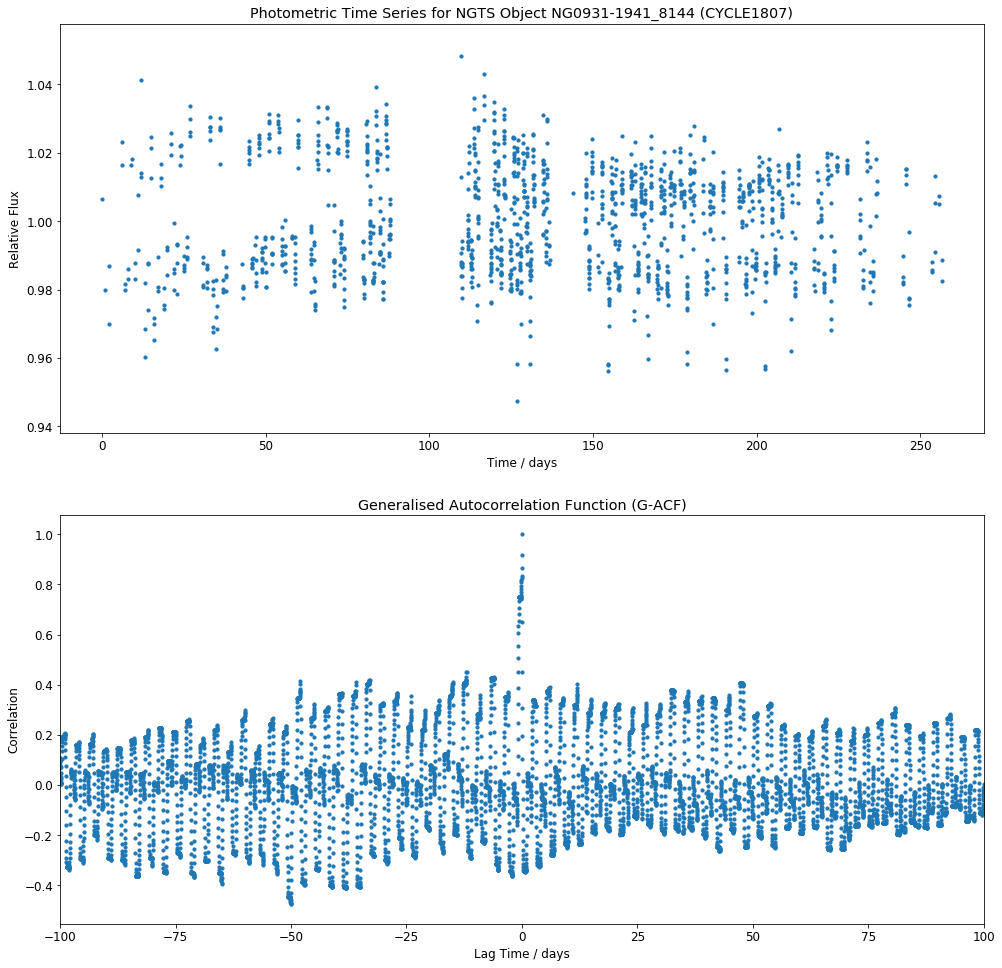

In [27]:
for field in fields.values():
    for obj in field:
        fig, (ax, ax1) = plt.subplots(2,1, figsize=(16.555118,16.555118))
        obj.min_lag = -obj.max_lag
        obj.calculate_autocorrelation()
        t = np.subtract(obj.timeseries_binned, obj.timeseries_binned[0])
        ax.scatter(t, obj.flux_binned, s=10)
        ax.set_xlabel("Time / days")
        ax.set_ylabel("Relative Flux")
        ax.set_title("Photometric Time Series for {}".format(obj))
    #     ax.set_ylim([0.95, 1.05])

        ax1.scatter(obj.lag_timeseries, obj.correlations, s=10)
        ax1.set_xlabel("Lag Time / days")
        ax1.set_ylabel("Correlation")
        ax1.set_title("Generalised Autocorrelation Function (G-ACF)")
        ax1.set_xlim([-100, 100])
        fig.savefig("/home/jtb34/GitHub/GACF/example/hpc/G_ACF_{}_{}.pdf".format(obj.field, obj.obj))
#     plt.show()

In [ ]:
new_moon_epoch = field.get_new_moon_epoch()

[43.473300165837486, 54.27412008281574, 35.492011914432716, 77.1919905771496, 15.14407856730214, 0.041978570662208496]


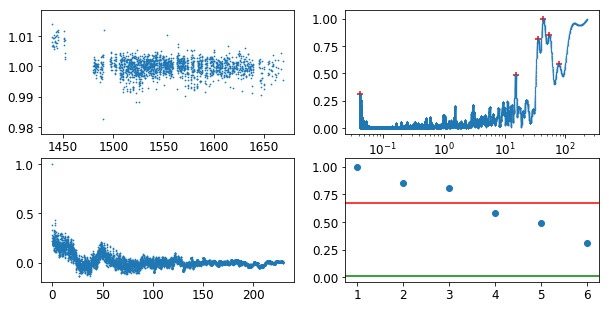

TypeError: 'NoneType' object has no attribute '__getitem__'

In [44]:
bruh = obj.calculate_periods_from_autocorrelation()
print obj.periods
do_plots(obj)

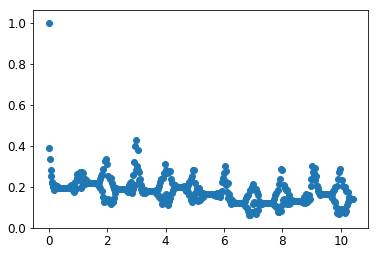

In [49]:
n = 500
plt.scatter(obj.lag_timeseries[:n], obj.correlations[:n])
plt.show()

In [ ]:
pobjs = {}
for obj in field:
    for p in obj.cleaned_refined_periods:
        if p in pobjs:
            pobjs[p].append((obj.obj, len(obj.periods)))
        else:
            pobjs[p] = [(obj.obj, len(obj.periods))]
# for p, objs in pobjs.iteritems():
#     if len(objs) > 10:
#         print p, objs
#         for o in objs:
#             obj = field[o]
#             if obj.ft is None:
#                 obj.calculate_periods_from_autocorrelation()
#             print obj
#             do_plots(obj)

for b in sorted([(k,v) for k, v in pobjs.iteritems()], key=lambda x: len(x[1]), reverse=True):
    print '*******'
    print 'Period {} days, {} objects'.format(b[0], len(b[1]))
    for o in b[1]:
        if o[1] < 10 and len(b[1]) == 1:
            print o
            obj = field[o[0]]
            obj.calculate_periods_from_autocorrelation()
            print obj
            do_plots(obj)
    print '*******'

In [26]:
def do_plots(obj):
    n=4
    fig, ax = plt.subplots(2,2, figsize=(10, 5))
    ax[0,0].scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
    ax[1,0].scatter(obj.lag_timeseries, obj.correlations, s=0.5)
    ft_max = max(obj.ft)
    ax[0,1].plot(obj.period_axis, obj.ft/ft_max, lw=0.5, marker='.', ms=0.5)
    ax[0,1].set_xscale('log')
#     ax[0,1].set_xlim(right=100)
    ax[0,1].scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes]/ft_max, marker='+', s=40, c='r')
    peaks = obj.ft[obj.peak_indexes] / ft_max
    peaksplot = np.linspace(1, len(peaks), len(peaks))
    ax[1,1].scatter(peaksplot, peaks)
    ft_ave = np.mean(obj.ft) / ft_max
    peaks_ave = np.mean(peaks)
    ax[1,1].axhline(y=ft_ave, c='g', label='FT mean')
    ax[1,1].axhline(y=peaks_ave, c='r', label='Peaks mean')
    plt.show()
    p = obj.cleaned_refined_periods[0]
    t = obj.timeseries_binned
    f = obj.flux_binned
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(phase_app, data_app, s=0.1)
    ax.scatter(binned_phase_app, binned_data_app, s=5, c='r')
    ax.axvline(x=0, lw=0.1, c='k', ls='--')
    ax.axvline(x=1, lw=0.1, c='k', ls='--')
    ax.set_title('Data phase folded on {} day period'.format(p))
    plt.show()

In [7]:
long_periods = {}
min_p = np.inf
max_p = 0
# investigate long periods
for k, v in pdics.iteritems():
    objs = []
    periods = []
    for o, ps in v.iteritems():
        for p in ps:
            if p:
                if p < min_p:
                    min_p = p
                if p > max_p:
                    max_p = p
                objs.append(o)
                periods.append(p)   
    prot_f = np.array(periods)
    idx_sort = np.argsort(prot_f)
    sorted_prot = prot_f[idx_sort]
    vals, idx_start, count = np.unique(sorted_prot, return_counts=True, return_index=True)
    # sets of indices
    res = np.split(idx_sort, idx_start[1:])
    #filter them with respect to their size, keeping only items occurring more than once
#     vals = vals[count <= 1]
    res = filter(lambda x: x.size <= 1, res)
    #     res = [x for x in res if len(x) <=1]
    if len(res) > 0:
        idxu = np.hstack(res)
        long_periods[k] = np.array(objs)[idxu].tolist()
    else:
        idxu = []

print 'Period range {} -> {} days'.format(min_p, max_p)

Period range 1.002 -> 133.203 days


In [24]:
# from astropy.time import Time
# def split_and_compute_percentile_per_specified_time_period(t, f, tref, dt, percentiles=[10., 90.], nsigma=None):
#     with np.errstate(divide='ignore', invalid='ignore'):
#         t = np.array(t)
#         f = np.array(f)
#         fpn = []
#         treg = np.concatenate([np.r_[tref: t.min(): -dt][::-1],
#                                np.r_[tref + dt: t.max():  dt]])
#         nreg = len(treg)
#         freg = np.zeros(nreg) + np.nan
#         for j in np.arange(nreg):
#             l = np.logical_and((t >= treg[j]), (t < treg[j] + dt))
#             if l.any():
#                 # compute
#                 fsl = f[l]
#                 if nsigma:
#                     med, sig = utils.medsig(fsl)
#                     fsl[abs(med - fsl) > abs(nsigma * sig)
#                         ] = np.nan  # sigma clip
#                 perc = np.nanpercentile(fsl, percentiles)
#                 fpn.append(perc[1] - perc[0])
#         fpn = np.array(fpn)
#     #     spread = np.median(fpn[:,1]-fpn[:,0])
#     #     spread = np.median(np.diff(fpn))
#         spread = np.nanmedian(fpn)
#     return spread

In [9]:
nums = 0
for k, v in long_periods.iteritems():
    print k, len(v)
    nums += len(v)
    
# print long_periods
print 'total', nums

NG0458-3056 30
NG0535-0523 209
NG0518-3633 32
NG2028-2518 53
NG0523-0104 133
NG0532-3633 22
NG1114-3056 44
NG1416-2518 29
NG0450-3633 16
NG0914-1652 43
NG0613-3633 49
NG1112-3345 48
NG0304-1115 32
NG0504-3633 32
NG2346-3633 15
NG1200-3633 59
NG0931-1941 39
NG0537-3056 33
NG0511-3056 25
NG0448-3922 23
NG0531-0826 92
NG0348-3345 22
NG2142+0826 36
NG0445-3056 31
NG0524-3056 36
NG0612-2518 59
NG0618-6441 72
NG0549-3345 48
NG0004-2950 51
NG0409-1941 32
NG0603-3056 59
NG1429-3056 44
NG0522-2518 42
NG0603-3345 49
NG2331-3922 21
NG0509-3345 48
NG0456-3345 31
NG2126-1652 27
NG0502-3922 27
NG0616-3345 113
NG0353-3056 26
total 1932


In [52]:
long_periods = {#'NG0409-1941': [9659],
#                 'NG1112-3345': [4537],
                'NG0535-0523': [10614],#[16614],
#                 'NG2028-2518': [9463],
#                 'NG0004-2950': [626],
#                 'NG1416-2518': [47126]
#                 'NG1200-3633': [59459, 3356, 60078]               
               }

In [53]:
for k, v in long_periods.iteritems():
    print k, v
# cool_objs = [5891, 7649,3728, 4294, 7710]

NG0535-0523 [10614]


matched 8957 of 9353 files. Loaded 1 objects
****** NGTS Object NG0535-0523_10614 (CYCLE1807) ******
[4.01384168]
[4.039]
[883.81367058]
Signal spread 15.5932431098 times larger than daily spread
Phased signal spread 4.14275119105 times larger than 0.05 phase spread
Phased signal spread per period 47.3183302922 times larger than 0.05 phase spread
###### OBJECT OK ######


/home/jtb34/.conda/envs/env_gacf/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in double_scalars


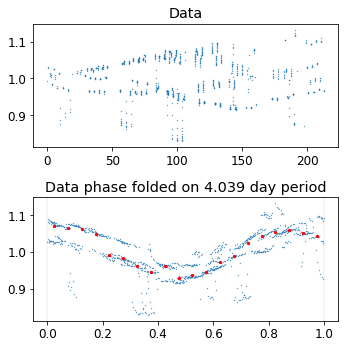

In [54]:
import NGTS.NGTS_Field as NGTS_Field

reload(NGTS_Field)

fields = {}
# gfields = {}
good_objs = 0
for fieldname, objs in long_periods.iteritems():
    if len(objs) < 1:
        continue
#     objs = np.array(objs)[np.random.randint(0, len(objs)-1, 10)].tolist()
#     if fieldname not in ['NG0409-1941']:
#         continue
# for fieldname, objs in {'NG0004-2950': [2048]}.iteritems():
    t1 = time.time()
    field = NGTS_Field.return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', 
                                               include_empty_objects=True, silent=True, obj_ids=objs)
#     field = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=pdics[fieldname].keys())
    t2 = time.time()
    field = load_gaia_params(field)
    t3 = time.time()
    for obj in field:
        try:
            obj.cleaned_refined_periods = pdics[fieldname][obj.obj]
        except KeyError:
            obj.cleaned_refined_periods = None
    
#     gfield = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=obj_lists[fieldname])
#     gfield = load_gaia_params(gfield)
    t4 = time.time()
    fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
    field.load_from_fits(fits_file, obj_ids=objs, method='fitsio', sparse_ids=True)
    t5 = time.time()
    new_moon_epoch = field.get_new_moon_epoch()
    
    n = 0
    for obj in field:
#         if obj.obj not in cool_objs:
#             continue
#         if n < 5:
#             n += 1
#             continue
#         if n > 10:
#             break
        print '****** {} ******'.format(obj)
        print obj.periods
        print obj.cleaned_refined_periods
        print obj.peak_size
        obj.nsig2keep = 5
        
        t = obj.timeseries_binned
        f = obj.flux_binned
#         p = pdics[fieldname][obj.obj][0]
        if obj.cleaned_refined_periods is not None:
            p = obj.cleaned_refined_periods[0] 
        else:
            p = obj.periods[3]
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        tref = (Time(Time(np.median(t) + utils.NGTS_EPOCH, format='jd').to_datetime()
                     .replace(hour=12, minute=0, second=0)).jd - utils.NGTS_EPOCH)
        pref = np.mod(tref - new_moon_epoch, p) / p 
        
        spread1 = split_and_compute_percentile_per_specified_time_period(t, f, tref, 1, nsigma=3)
        spread2 = split_and_compute_percentile_per_specified_time_period(t, f, tref, p)
        
        signal_spread_ratio = spread2 / spread1
        print 'Signal spread {} times larger than daily spread'.format(signal_spread_ratio)
        
        spread1_phase = split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 0.05, nsigma=3)
        spread2_phase = split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 1)
        
        phase_spread_ratio = spread2_phase / spread1_phase
        print 'Phased signal spread {} times larger than 0.05 phase spread'.format(phase_spread_ratio)
        
        phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned)
        
        spread_ratios = []
        for pp, pf in zip(phases, datas):
            try:
                spread1_phase = split_and_compute_percentile_per_specified_time_period(pp, pf, 0, 0.05, nsigma=3)
                spread2_phase = split_and_compute_percentile_per_specified_time_period(pp, pf, 0, 1)
            except ValueError:
                phase_spread_ratio = np.nan
            else:
                phase_spread_ratio = spread2_phase / spread1_phase
            spread_ratios.append(phase_spread_ratio) if phase_spread_ratio != np.inf else spread_ratios.append(np.nan)
#         print spread_ratios
#         print np.nanpercentile(spread_ratios, [10., 50., 90.])
#         print np.nanmean(spread_ratios)
        phased_signal_spread_ratio =  np.nanmean(spread_ratios)
        print 'Phased signal spread per period {} times larger than 0.05 phase spread'.format(phased_signal_spread_ratio)
        
        if signal_spread_ratio > 2.5 and phase_spread_ratio > 1.4:
            print "###### OBJECT OK ######"
            good_objs += 1
        else:
#             pass
            print 'Rejected object on signal strength'
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
        ax1.scatter(t-t[0], f, s=0.1)
        ax1.set_title('Data'.format(p))
        ax2.scatter(phase_app, data_app, s=0.1)
        ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
        ax2.axvline(x=0, lw=0.1, c='k', ls='--')
        ax2.axvline(x=1, lw=0.1, c='k', ls='--')
        ax2.set_title('Data phase folded on {} day period'.format(p))
        fig.tight_layout()
        plt.show()

        n += 1
    
#     for obj in field:
#         obj.min_lag=0.
#         obj.calculate_periods_from_autocorrelation()
#         print obj.clean_periods()
#         fourier_ok = obj.check_fourier_ok(nlim=5)
#         print fourier_ok
#         if fourier_ok:
#             obj.clean_periods()
#             is_moon = obj.check_moon_detection(field.new_moon_epoch)
#             if is_moon:
#                 moon_ok = obj.remove_moon_and_check_ok(field.new_moon_epoch)
#             else:
#                 moon_ok = True
#             print moon_ok
    fields[fieldname] = field
#     t6 = time.time()
# #     gfields[fieldname] = gfield

# #     print '{} objects with periods, {} total'.format(field.num_objects, gfield.num_objects)
#     print 'Loaded field in {} seconds'.format(t2-t1)
#     print 'Loaded Gaia params in {} seconds'.format(t3-t2)
#     print 'Loaded FITS data in {} seconds'.format(t5-t4)
#     print 'Calculated GACF in {}'.format(t6-t5)
#     print 'Finished Field in {} seconds'.format(t6-t1)

In [68]:
print 'good', good_objs
print'total', nums

good 1
total 1932


In [13]:
# for k, v in obj.__dict__.iteritems():
#     if type(v) == np.float64:
#         print k, v

In [27]:
import logging
logger = logging.getLogger()
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter())
logger.addHandler(sh)
logger.setLevel(logging.INFO)
logger.info('Yeet')

Yeet


In [28]:
for obj in field:
    obj.logger = logger
    print obj.check_signal_significance(epoch=field.new_moon_epoch)

Signal spread 7.16776799895 times larger than daily spread
Phased signal spread 2.39454651409 times larger than 0.05 phase spread


True


In [21]:
def split_phase(phase, data, timeseries=None, buff=0.9, nperiods=1):
    # returns list of lists of data & phases for complete periods (requires sorted phased timeseries)
    # buff => require this much phase coverage in first and last segments
    phases = []
    datas = []
    timeseriess = [] if timeseries is not None else None
    
    idx_changes = np.where(np.diff(phase) < 0)[0][::nperiods]
#     print idx_changes
    use_first = True if (phase[0] < 1.0 - buff) else False
    use_last = True if (phase[-1] > buff) else False

    if use_first:
        phases.append(phase[:idx_changes[0]])
        datas.append(data[:idx_changes[0]])
        if timeseriess is not None:
            timeseriess.append(timeseries[:idx_changes[0]])
        
    for i, idx in enumerate(idx_changes[:-1]):
        phases.append(phase[idx+1:idx_changes[i+1]])
        datas.append(data[idx+1:idx_changes[i+1]])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx+1:idx_changes[i+1]])
        
    if use_last or np.any(np.diff(phase[idx_changes[-1]+1:]) < 0):
        phases.append(phase[idx_changes[-1]:])
        datas.append(data[idx_changes[-1]:])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx_changes[-1]:])
    if timeseriess is not None:    
        return phases, datas, timeseriess
    else:
        return phases, datas
#     save = False
#     phase_count = 0
#     for p, d in zip(phase, data):
        

In [188]:
phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned, nperiods=2)

[285 823]


NameError: name 'timeseriess' is not defined

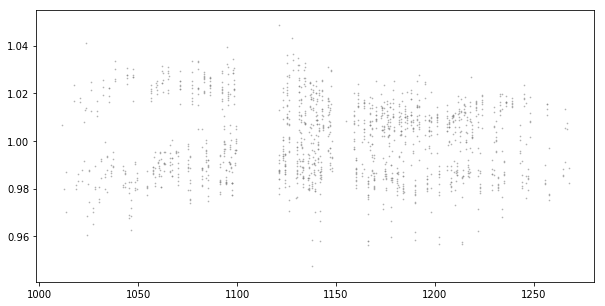

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(obj.timeseries_binned, obj.flux_binned, s=0.5, alpha=0.5, c='gray')
for t, d in zip(timeseriess, datas):
    ax.scatter(t, d, s=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(phase_app, data_app, s=0.5, alpha=0.5, c='gray')
for p, d in zip(phases, datas):
    ax.scatter(p, d, s=0.5)
plt.show()

In [19]:
from astropy.time import Time
def split_and_compute_percentile_per_specified_time_period(t, f, tref, dt, percentiles=[10., 90.], nsigma=None):
    with np.errstate(divide='ignore', invalid='ignore'):
        t = np.array(t)
        f = np.array(f)
        fpn = []
        treg = np.concatenate([np.r_[tref: t.min(): -dt][::-1],
                               np.r_[tref + dt: t.max():  dt]])
        nreg = len(treg)
        if nreg == 0 and (np.min(t) + dt > np.max(t)):
            # take whole series as input
            treg = [np.min(t)]
            nreg = 1
        freg = np.zeros(nreg) + np.nan
        for j in np.arange(nreg):
            l = np.logical_and((t >= treg[j]), (t < treg[j] + dt))
            if l.any():
                # compute
                fsl = f[l]
                if nsigma:
                    med, sig = utils.medsig(fsl)
                    fsl[abs(med - fsl) > abs(nsigma * sig)
                        ] = np.nan  # sigma clip
                perc = np.nanpercentile(fsl, percentiles)
                fpn.append(perc[1] - perc[0])
        fpn = np.array(fpn)
    #     spread = np.median(fpn[:,1]-fpn[:,0])
    #     spread = np.median(np.diff(fpn))
        spread = np.nanmedian(fpn)
    return spread

In [126]:
spread_ratios = []
for p, f in zip(phases, datas):
    try:
        spread1_phase = split_and_compute_percentile_per_specified_time_period(p, f, 0, 0.05, nsigma=3)
        spread2_phase = split_and_compute_percentile_per_specified_time_period(p, f, 0, 1)
    except ValueError:
        phase_spread_ratio = np.nan
    else:
        phase_spread_ratio = spread2_phase / spread1_phase
    spread_ratios.append(phase_spread_ratio) if phase_spread_ratio != np.inf else spread_ratios.append(np.nan)
print spread_ratios
print np.nanpercentile(spread_ratios, [10., 50., 90.])
print np.nanmean(spread_ratios)

[2.514833080424966, 3.834839218146199, 3.946499918260622, 9.38276623433593]
[2.91083492 3.89066957 7.75188634]
4.919734612791929


Spread ratio : 2.51483308042


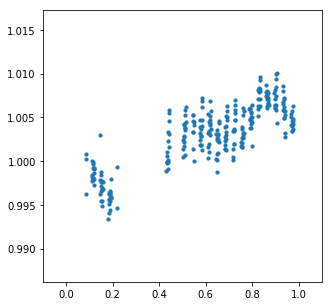

Spread ratio : 3.83483921815


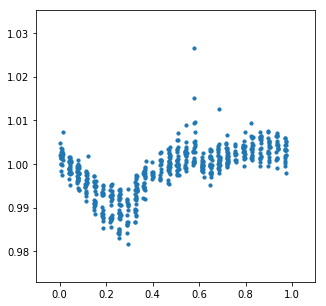

In [170]:
for i, p in enumerate(phases):
#     if np.isfinite(spread_ratios[i]):
    print 'Spread ratio : {}'.format(spread_ratios[i])
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim([-0.1, 1.1])
    ax.scatter(p, datas[i], s=10)
    plt.show()
    plt.close()